In [5]:
import os
os.chdir('..')

In [6]:
pwd

'c:\\Users\\nimee\\OneDrive\\Documents\\DDP\\Parametric_Roll_Detection'

In [7]:
%load_ext autoreload
%autoreload 2

In [9]:
from src.data.Dataset import Dataset as DS
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from src.models.Model_OneShotDNN import OneShotDNN

In [10]:
# Dataset generator
input_dim   = 30*4
pred_dim    = 30*2
shift       = pred_dim
data        = DS(input_dim, pred_dim, shift, skip=1, hop=0.1, normalizer=1, batch_size=16)

In [11]:
data.Train.element_spec

(TensorSpec(shape=(None, 120, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 60, 1), dtype=tf.float64, name=None))

In [31]:
sam_x, sam_y = next(iter(data.Train))

In [39]:
sam_x[:,:,0].shape

TensorShape([16, 120])

In [44]:
sam_model = MyModel(120, 60)

In [51]:
sam_pred = sam_model(sam_x)

In [52]:
sam_pred.shape

TensorShape([16, 60])

In [53]:
sam_model.summary()

Model: "my_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 128)               15488     
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dense_34 (Dense)            (None, 60)                3900      
                                                                 
 sequential_5 (Sequential)   (None, 60)                48316     
                                                                 
Total params: 48,316
Trainable params: 48,316
Non-traina

In [6]:
# Loss functions
# Regression loss
MSE_loss = tf.keras.losses.MeanSquaredError()

# Metrics
# Regression metrics
MAPE = tf.keras.metrics.MeanAbsolutePercentageError()
MAE = tf.keras.metrics.MeanAbsoluteError()

In [26]:
INPUT_DIM = data.xshape
OUTPUT_DIM = data.yshape

In [27]:
print('Input dim:', INPUT_DIM)
print('Output dim:', OUTPUT_DIM)

Input dim: 120
Output dim: 60


In [48]:
oneshot_dnn_model = MyModel(INPUT_DIM, OUTPUT_DIM)

In [49]:
oneshot_dnn_model.compile(optimizer='adam', loss=MSE_loss, metrics=[MAPE, MAE])

In [50]:
oneshot_dnn_model.fit(data.Train, epochs=10, validation_data=data.Val)

Epoch 1/10
2738/2738 [==============================] - 10s 4ms/step - loss: 7.7305 - mean_absolute_percentage_error: 580.0671 - mean_absolute_error: 1.1968 - val_loss: 3.1606 - val_mean_absolute_percentage_error: 371.0836 - val_mean_absolute_error: 0.8386
Epoch 2/10
1164/2738 [===========>..................] - ETA: 5s - loss: 16.3025 - mean_absolute_percentage_error: 1579.7006 - mean_absolute_error: 2.5835

KeyboardInterrupt: 

In [11]:
MAX_EPOCHS = 20

def lr_optimizer(model, window, patience=2):

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-5 * 10**(epoch / 4))

  model.compile(loss=MSE_loss,
                optimizer=tf.optimizers.Adam(),
                metrics=[MAPE, MAE])

  history = model.fit(window.Train, epochs=MAX_EPOCHS,
                      validation_data=window.Val,
                      callbacks=[lr_scheduler])
  return history

In [12]:
history = lr_optimizer(oneshot_dnn_model, data)

Epoch 1/20
2738/2738 [==============================] - 12s 4ms/step - loss: 15.6849 - mean_absolute_percentage_error: 587.8209 - mean_absolute_error: 1.9872 - val_loss: 8.6027 - val_mean_absolute_percentage_error: 181.5297 - val_mean_absolute_error: 1.5063 - lr: 1.0000e-05
Epoch 2/20
2738/2738 [==============================] - 12s 4ms/step - loss: 12.7619 - mean_absolute_percentage_error: 542.3986 - mean_absolute_error: 1.7522 - val_loss: 5.6270 - val_mean_absolute_percentage_error: 340.7968 - val_mean_absolute_error: 1.1838 - lr: 1.7783e-05
Epoch 3/20
2738/2738 [==============================] - 12s 4ms/step - loss: 8.6403 - mean_absolute_percentage_error: 757.9999 - mean_absolute_error: 1.3954 - val_loss: 3.7035 - val_mean_absolute_percentage_error: 351.5448 - val_mean_absolute_error: 0.9316 - lr: 3.1623e-05
Epoch 4/20
2738/2738 [==============================] - 12s 4ms/step - loss: 7.4172 - mean_absolute_percentage_error: 1104.4669 - mean_absolute_error: 1.2635 - val_loss: 3.4462

(1e-05, 0.001, 0.0, 20.0)

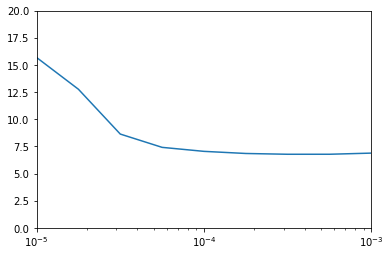

In [14]:
lrs = 1e-5 * (10 ** (np.arange(MAX_EPOCHS) / 4))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-5, 1e-3, 0, 20])

In [15]:
oneshot_dnn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(INPUT_DIM,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_DIM, activation='linear')
])

In [13]:
MAX_EPOCHS_TRAINING = 50

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-5 * 10**(epoch / 4))

  model.compile(loss=MSE_loss,
                optimizer=tf.optimizers.Adam(learning_rate=1e-5),
                metrics=[MAPE, MAE])

  history = model.fit(window.Train, epochs=MAX_EPOCHS_TRAINING,
                      validation_data=window.Val,
                      callbacks=[early_stopping])
  return history

In [14]:
history_training = compile_and_fit(oneshot_dnn_model, data)

Epoch 1/50


ValueError: in user code:

    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\nimee\OneDrive\Documents\DDP\ddp\lib\site-packages\keras\losses.py", line 1329, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 120 and 60 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](my_model/dense_4/BiasAdd, Cast)' with input shapes: [?,120,60], [?,60,1].


In [18]:
val_performance = oneshot_dnn_model.evaluate(data.Val)
test_performance = oneshot_dnn_model.evaluate(data.Test)

392/392 [==============================] - 1s 3ms/step - loss: 4.4440 - mean_absolute_percentage_error: 221.3841 - mean_absolute_error: 0.9907


In [20]:
print('Validation MSE_loss: {:.2f}'.format(val_performance[0]))
print('Validation MAPE:     {:.2f}'.format(val_performance[1]))
print('Validation MAE:      {:.2f}'.format(val_performance[2]))
print('Test MSE_loss:       {:.2f}'.format(test_performance[0]))
print('Test MAPE:           {:.2f}'.format(test_performance[1]))
print('Test MAE:            {:.2f}'.format(test_performance[2]))

Validation MSE_loss: 3.30
Validation MAPE:     305.22
Validation MAE:      0.83
Test MSE_loss:       4.44
Test MAPE:           221.38
Test MAE:            0.99


In [21]:
oneshot_dnn_model.save('models/oneshot_dnn_model')

INFO:tensorflow:Assets written to: models/oneshot_dnn_model\assets
